# Model 1 - Optimizing Revenue Generation

In [1]:
# Import required packages
import datetime
import os
import zipfile
import numpy as np
import pandas as pd
import math
import pyomo.environ as pe
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
def ceil_dt(dt, delta):
    # This function calculate the ceiling of a date-time based on given delta
    return datetime.datetime.min + math.ceil((dt - datetime.datetime.min) / delta) * delta

def read_lbmp_data(date_entry='2022-08-06'):
    # reads LBMP data for a given date
    year, month, day = map(int, date_entry.split('-'))
    optimization_date = datetime.date(year, month, day)
    month_folder='../Data/2022_NYISO_LBMP_zonal/'+str(optimization_date.strftime('%Y%m'))+'01realtime_zone_csv'
    file_name=str(optimization_date.strftime('%Y%m%d'))+'realtime_zone.csv'

    # Check if the month folder exists, otherwise unzip the zipped month data folder
    if not os.path.exists(month_folder):
        with zipfile.ZipFile(month_folder+'.zip', 'r') as zip_ref:
            zip_ref.extractall(month_folder)


    # Read data from csv file
    df = pd.read_csv(month_folder+"/"+file_name)
    
    # Keep only 'Time Stamp' and 'LBMP ($/MWHr)' for the NYC zone data and save it as lbmp
    lbmp = df[df['Name'] == 'N.Y.C.'][['Time Stamp','LBMP ($/MWHr)']].reset_index(drop=True)
    
    return lbmp

def calc_avg_lbmp(input_lbmp,delta_t=5):
    # delta_t=int(input('Please enter the resolution of the model as multipicant of 5 minutes (between 5 and 60 minutes):'))
    assert delta_t>=5, 'Time resolution must be at least 5 minutes.'
    assert delta_t<=60, 'Time resolution must be at most 60 minutes.'
    assert delta_t % 5==0, 'Time resolution must be a multipicant of 5 minutes.'
    time_resolution = datetime.timedelta(minutes=delta_t)
    lbmp=input_lbmp
    # For each time stamp, create an 'Agg Time Stamp' which is the ceiling of the time stamp with delta_t
    lbmp['Agg Time Stamp']=lbmp['Time Stamp'].apply(lambda x: ceil_dt(datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S'),time_resolution))
    # For each 'Agg Time Stamp' calculate the mean LBMP ($/MWHr)
    lbmp_avg = lbmp.groupby('Agg Time Stamp').mean()
    
    # From now, consider 'Agg Time Stamp' as 'Time Stamp'
    lbmp_avg=lbmp_avg.rename_axis('Time Stamp')
    
    return lbmp_avg['LBMP ($/MWHr)']



# Optimization Model
## Decision Variables:

charge_power[t]= charged power (KW) at time t

discharge_power[t]= discharged power (KW) at time t

Note: Only 85% of the discharged power is utilized (given the AC-AC round trip efficiency of 85%) and the rest is lost.

energy_level[t]= energy level (KWh) of the storage at the end of time t



## Objective Function

The objective of this model is to maximize the total revenue generation based on the NYISO LBMP for the NYC zone. Then,

$maximize\ \ \sum_{t=1}^T (LBMP[t]/1000)*(\Delta/60)*(round\_trip\_efficiency*discharge\_power[t]-charge\_power[t])$,

where $\Delta$ is the time interval length in minutes, and T is the total number of time intervals in the given day. Note that $T=24*60/\Delta$. The provided LBMP is in (\\$/MWh) unit and to convert it to (\\$/kWh) we divide LBMP by 1000. 



## Constraints:

energy_balance[t]: energy level (KWh) of the storage at the end of time t should be eqaul to 
the energy level from previous time plus net charged energy which is the difference between 
the charge power and discharged power multiplied by the time interval length (in hours)


$energy\_level[t]=energy\_level[t-1]+\Delta/60*(charge\_power[t]-discharge\_power[t]), \forall t=2,\cdots,T$.

For the first time period, the energy balance equation can be writen as 

$energy\_level[1]=(\Delta/60)*(charge\_power[1]-discharge\_power[1])$,

For each time peroid, charge_power and discharge_power should be between 0 and 100KW. 
Also, energy_level should be between 0 and 200KWh.
These bounded are provided with the definition of the corresponding variables.

$0\le charge\_power[t]\le 100$

$0\le discharge\_power[t]\le 100$

$0\le energy\_level[t]\le 200$

There is a daily discharged energy limit of 200KWh. Then,

$(\Delta/60)*\sum_{t=1}^T (discharge\_power[t]) \le 200$

In the proposed model, the AC-AC round trip efficiency is defined as the ratio of the useful power output to the input power when charging and discharging a battery. Specifically, if the battery is charged for one hour at a rate of 1 kilowatt (kW), it will store 1 kilowatt-hour (kWh) of energy. However, when the battery is discharged, only 0.85 kWh of the stored energy will be available for use, and the remaining 0.15 kWh will be lost as waste. 


In [3]:
def optimize_revenue(lbmp,delta_t=5):
    
    
    # create the optimization model
    opt_model = pe.ConcreteModel()
    
    # optimization model data which is not in the csv data file
    round_trip_efficiency=0.85
    daily_discharged_energy_limit=200
    discharge_power_bound=100
    charge_power_bound=100
    energy_level_bound=200
    
    # index for x
    NT=lbmp.shape[0]
    idx=range(NT)
    
    # create decision variables with the corresponding bounds
    opt_model.discharge_power  = pe.Var(idx, bounds=(0,discharge_power_bound))
    opt_model.charge_power  = pe.Var(idx, bounds=(0,charge_power_bound))
    opt_model.energy_level  = pe.Var(idx, bounds=(0,energy_level_bound))

    # create objective function
    opt_model.revenue = pe.Objective(expr =sum(lbmp[t]/1000*(delta_t/60)*(round_trip_efficiency*opt_model.discharge_power[t]-opt_model.charge_power[t]) for t in idx), sense=pe.maximize)

    # define the energy balance constraint for each time stamp
    def energy_balance_rule(model, t):
        if t == 0:
            return model.energy_level[t]==delta_t/60*(model.charge_power[t]-model.discharge_power[t])
        else: return model.energy_level[t]==model.energy_level[t-1]+delta_t/60*(model.charge_power[t]-model.discharge_power[t])

    opt_model.energy_balance=pe.Constraint(idx,rule=energy_balance_rule)
    
    # define the constraint for daily discharged energy limit
    opt_model.daily_discharge=pe.Constraint(expr=delta_t/60*sum(opt_model.discharge_power[t] for t in idx) <=daily_discharged_energy_limit ) 
    
    opt = pe.SolverFactory('glpk')
    result_obj = opt.solve(opt_model, tee=False)
    
    # To see the details of the optimization model output you can uncomment the following lines of code
    #opt_model.pprint()
    #opt_model.display()
    
    # get the optimal revenue and save it
    optimal_revenue=round(pe.value(opt_model.revenue),2)
    
    # Prepare a summary output data frame which include lbmp ($/KWHr), 'charge power', 'discharge power', 
    # 'net charge power', 'energy level', and 'revenue' for each time stamp
    summary_output=pd.DataFrame(index=lbmp.index)
    summary_output['LBMP ($/KWHr)']=lbmp/1000
    summary_output['charge power']=[pe.value(opt_model.charge_power[t]) for t in idx]
    summary_output['discharge power']=[pe.value(opt_model.discharge_power[t]) for t in idx]
    summary_output['net charge power']=(summary_output['charge power']-summary_output['discharge power'])
    summary_output['energy level']=[pe.value(opt_model.energy_level[t]) for t in idx]
    summary_output['revenue']=summary_output['LBMP ($/KWHr)']*(delta_t/60)*(round_trip_efficiency*summary_output['discharge power']-summary_output['charge power'])
    
    # Calculate total discharged throughput and total charging cost
    total_discharged_throughput=sum((delta_t/60)*round_trip_efficiency*summary_output['discharge power'][t] for t in range(NT))
    total_charging_cost=sum(summary_output['LBMP ($/KWHr)'][t]*(delta_t/60)*summary_output['charge power'][t] for t in range(NT))
    
    return summary_output,optimal_revenue,total_charging_cost,total_discharged_throughput

In [4]:
def visualize_output(summary_output,delta_t=5):
    
    # create the LBMP axis for the plot
    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.plot(summary_output.index, summary_output['LBMP ($/KWHr)'], label='LBMP ($/KWHr)')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('LBMP ($/KWHr)')

    # Format the x axis to show only hours and minutes
    time_form = DateFormatter('%h:%m')
    ax1.xaxis.set_major_formatter(time_form)
    
    locator = mdates.HourLocator(byhour=range(0, 24, 2))
    formatter = mdates.ConciseDateFormatter(locator)
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    

    # create the net charge power axis for the plot
    ax2 = ax1.twinx()
    bar_colors = ['red' if x > 0 else 'green' for x in summary_output['net charge power']]
    ax2.bar(summary_output.index, summary_output['net charge power'], alpha=0.5,width=0.04*delta_t/60, color=bar_colors, label='net charge energy')
    ax2.set_ylabel('net charge power (KW)')
    
    

    # add the title to the plot
    plt.title('LBMP and net charge power')

    # add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(lines1+lines2, labels1+labels2)
    
    # save the plot
    figname=str(summary_output.index[0].date())+'_'+str(delta_t)+'min.png'
    plt.savefig(figname)
    print('The plot for the optimal schedule of charging and discharging along with the LBMPs are saved as ', 
          figname,'. In this plot  red(green) bars show the (dis)charging power.')
    
    # show the plot
    plt.show()

In [5]:
def main_opt_algorithm(opt_date='2022-08-06',delta_t=30):
    
    # Read data to get the LBMPs
    LBMP=read_lbmp_data(opt_date)
    
    # Depending on the time resolution get the average LBMPs
    avg_LBMP=calc_avg_lbmp(LBMP,delta_t)
    
    # Run the optimization model and get the desired outpus
    summary_output,optimal_revenue,total_charging_cost,total_discharged_throughput=optimize_revenue(avg_LBMP,delta_t)
    
    # Save the summary output in an excel file
    outfile_name=str(opt_date+'_'+str(delta_t)+'min_output.xlsx')
    summary_output.to_excel(outfile_name)
    
    
    print('With delta_t='+str(delta_t)+', optimal total revenue is $'+str(optimal_revenue)+', and total battery storage charging cost is $',round(total_charging_cost,2),'.')
    print('Total battery storage discharged throughput is ', round(total_discharged_throughput,2),'(KWHr).')
    print('Summary of the model output including LBMP, charge power, discharge power, net charge power, storage energy level, and revenue at each time stamp is saved in '+outfile_name+'.'  )
    
    
    visualize_output(summary_output,delta_t)
    
    

With delta_t=5, optimal total revenue is $64.49, and total battery storage charging cost is $ 12.4 .
Total battery storage discharged throughput is  170.0 (KWHr).
Summary of the model output including LBMP, charge power, discharge power, net charge power, storage energy level, and revenue at each time stamp is saved in 2022-08-06_5min_output.xlsx.
The plot for the optimal schedule of charging and discharging along with the LBMPs are saved as  2022-08-06_5min.png . In this plot  red(green) bars show the (dis)charging power.


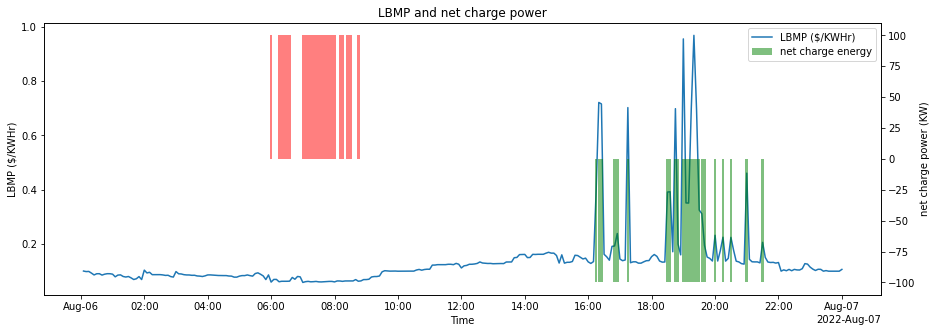

In [6]:
main_opt_algorithm(opt_date='2022-08-06',delta_t=5)

With delta_t=20, optimal total revenue is $55.21, and total battery storage charging cost is $ 12.65 .
Total battery storage discharged throughput is  170.0 (KWHr).
Summary of the model output including LBMP, charge power, discharge power, net charge power, storage energy level, and revenue at each time stamp is saved in 2022-08-06_20min_output.xlsx.
The plot for the optimal schedule of charging and discharging along with the LBMPs are saved as  2022-08-06_20min.png . In this plot  red(green) bars show the (dis)charging power.


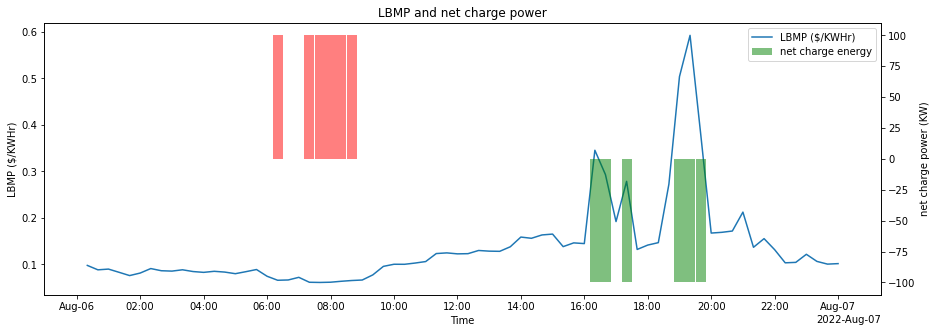

In [7]:
main_opt_algorithm(opt_date='2022-08-06',delta_t=20)

With delta_t=60, optimal total revenue is $45.83, and total battery storage charging cost is $ 12.67 .
Total battery storage discharged throughput is  170.0 (KWHr).
Summary of the model output including LBMP, charge power, discharge power, net charge power, storage energy level, and revenue at each time stamp is saved in 2022-08-06_60min_output.xlsx.
The plot for the optimal schedule of charging and discharging along with the LBMPs are saved as  2022-08-06_60min.png . In this plot  red(green) bars show the (dis)charging power.


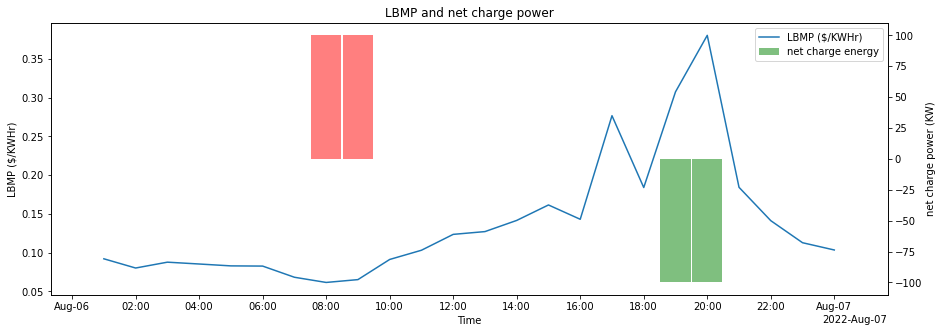

In [8]:
main_opt_algorithm(opt_date='2022-08-06',delta_t=60)

# Insights and Conclusions

The optimization model used in this study is a linear programming (LP) model, comprising $324(60/\Delta)=4320/\Delta$ non-negative real bounded variables and $24*60/\Delta+1=1440/\Delta+1$ constraints, apart from the variable bounds. For instance, with a time interval of $\Delta=5$ minutes, the model contains 864 non-negative real variables and 289 constraints, which can be solved within a short period.

As anticipated, the optimization model recommends charging the battery storage during times of low LBMPs and discharging it during the peak times of LBMPs.

After analyzing the outcomes for different time intervals such as $\Delta=5$, 20, and 60 minutes, it is evident that the revenue generation is higher when the model operates at shorter time resolutions. This is because the model can effectively leverage the profit generation opportunities available during the LBMP peaks. However, for larger time resolutions such as 60 minutes, the model calculates the average LBMP for each timestamp, which may cause it to miss out on high revenue-generating peaks. It is essential to note two subtle aspects in this context.

1. The first aspect to consider is that using a model with shorter time resolutions may lead to an increase in the size of the optimization model. However, since it is an LP model, the solution time is not expected to be affected significantly by the model size.

2. The second aspect to consider is that, in this project, we have assumed that the LBMP values are provided exactly for each 5-minute timestamp. However, in practice, these LBMPs need to be forecasted. Using shorter time resolutions for forecasting may result in higher errors, and therefore, the selection of an appropriate time resolution for forecasting LBMPs needs to be carefully evaluated.

# Suggestions and Improvements

In this project, only the fundamental constraints of the battery storage were taken into account. However, it is possible to incorporate more realistic constraints and relationships to make the model more accurate. For instance, constraints could be included to reduce battery degradation by restricting frequent charging and discharging or continuing charging until a certain level is reached. Incorporating these constraints would result in a more complex model, potentially leading to a mixed integer linear programming (MILP) model. Nonetheless, the solutions obtained using such a model would be more realistic.

One of the significant assumptions of the current model is that LBMPs are precisely known. However, in reality, LBMPs must be predicted, and these predictions are subject to errors. Therefore, a better optimization model should take into account the uncertainty and stochasticity of LBMPs. Here are some suggestions to handle this uncertainty:

1. Robust optimization: In this method, it is assumed that the uncertain data (LBMPs) belong to a particular uncertainty set. For example, each forecasted LBMP may have a confidence interval. The optimization model is then designed to optimize over the worst-case realization of the LBMPs. It is important to note that the worst-case realization of the LBMPs occurs after the decisions have been made and implemented. Therefore, if we plan to (dis)charge at a specific time stamp, the worst-case LBMP is the (lowest) highest value in its confidence interval. More complex robust models can also be considered.

2. Stochastic programming: In this approach, it is assumed that the LBMPs follow certain probability distributions. The optimization model is then designed to optimize a stochastic function such as expected total revenue or a specific quantile of the total revenue.

3. Adjustable or multi-stage robust/stochastic programming: In these methods, it is assumed that all prior LBMPs are known at time t, and future decisions are made based on this assumption.

4. Rolling horizon or look-ahead model: In this approach, an optimization model is built and solved for the entire planning horizon (e.g., next 24 hours). However, decisions are only implemented for the first time stamp. Then, new information is collected, and the model is reoptimized with the new horizon (e.g., next 24 hours starting from now).

